In [1]:
import sys

sys.path.append('./../../notebooks')
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import gensim
import spacy
import string
from notebooks.core import model_utils

from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset

In [2]:
df = pd.read_json('../../data/translated/emotions/equalized_emotions_dataset_pl.json')
df = df.drop(columns=['text'])
df.rename(columns={'emotions': 'label', 'text_pl': 'text'}, inplace=True)
df

,label,text
0,anger,Czuję się całkowicie chciwy
1,fear,Czuję się tak przytłoczony emocjami
2,surprise,Nie czułem efektu siły g Jestem oszołomiony Po...
3,anger,ive just got to tell you all that I feel Racze...
4,anger,"Powiedziałem ci, że przepraszam, że czujesz si..."
...,...,...
39995,joy,"czuję się ostatnio dość hojny, ponieważ pracuj..."
39996,love,"Czuję, że niektóre postacie nie zasługują na w..."
39997,fear,"Czuję strach w moich kościach, którego nie moż..."
39998,joy,Czułem się bardziej kreatywny i mniej jak czys...


In [3]:
ordered_class_labels = {
    "joy": 0,
    "love": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "fear": 5,
}
df = df.replace({"label": ordered_class_labels})
df

,label,text
0,4,Czuję się całkowicie chciwy
1,5,Czuję się tak przytłoczony emocjami
2,2,Nie czułem efektu siły g Jestem oszołomiony Po...
3,4,ive just got to tell you all that I feel Racze...
4,4,"Powiedziałem ci, że przepraszam, że czujesz si..."
...,...,...
39995,0,"czuję się ostatnio dość hojny, ponieważ pracuj..."
39996,1,"Czuję, że niektóre postacie nie zasługują na w..."
39997,5,"Czuję strach w moich kościach, którego nie moż..."
39998,0,Czułem się bardziej kreatywny i mniej jak czys...


In [4]:
full_dataset = Dataset.from_pandas(df).remove_columns("__index_level_0__")
full_dataset

Dataset({
    features: ['label', 'text'],
    num_rows: 40000
})

In [5]:
# Train set: 80%, Validation set: 10%, Test set: 10%
_, _, test_dataset = model_utils.split_train_val_test(
    full_dataset,
    train_size=0.8,
    test_size_of_val_test_batch=0.5,
    shuffle=True,
    seed=42)
test_dataset

Dataset({
    features: ['label', 'text'],
    num_rows: 4000
})

In [6]:
# Load models
version = "1"
trained_bert = os.path.join("./../../trained_models/emotions_pl_bert_5", version)
trained_gpt = os.path.join("./../../trained_models/emotions_pl_gpt2_2", version)
trained_word2vec = os.path.join("./../../trained_models/emotions_pl_word2vec_external_1", version)

bert = tf.keras.models.load_model(trained_bert)
gpt2 = tf.keras.models.load_model(trained_gpt)
word2vec = tf.keras.models.load_model(trained_word2vec)

In [7]:
bert.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (Custom>TFBertMainLayer multiple                  132121344 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  4614      
Total params: 132,125,958
Trainable params: 132,125,958
Non-trainable params: 0
_________________________________________________________________


In [8]:
gpt2.summary()

Model: "tfgp_t2for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
score (Dense)                multiple                  4608      
_________________________________________________________________
transformer (Custom>TFGPT2Ma multiple                  124439808 
Total params: 124,444,416
Trainable params: 124,444,416
Non-trainable params: 0
_________________________________________________________________


In [9]:
word2vec.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               51712     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 1

In [10]:
# Create BERT tokenizer and collator
bert_checkpoint = "dkleczek/bert-base-polish-uncased-v1"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_checkpoint, model_max_length=512)


def tokenize_for_bert(example):
    return bert_tokenizer(example["text"], truncation=True)


bert_tokenized_test_dataset = test_dataset.map(tokenize_for_bert, batched=True)

bert_input_columns = ["attention_mask", "input_ids", "token_type_ids"]
bert_label_columns = ['label']
bert_batch_size = 16
bert_data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer, return_tensors="tf")
bert_tf_dataset = model_utils.convert_to_tf_dataset(bert_tokenized_test_dataset, bert_input_columns, bert_label_columns,
                                                    bert_data_collator, bert_batch_size)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [11]:
# Create GPT2 tokenizer
gpt_checkpoint = MAX_TOKENS = 128
EOS_TOKEN = "<|endoftext|>"
checkpoint = "flax-community/papuGaPT2"

gpt2_tokenizer = AutoTokenizer.from_pretrained(
    checkpoint,
    eos_token=EOS_TOKEN,
    pad_token=EOS_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True,
)

gpt2_tokenizer.padding_side = "left"


def tokenize_for_gpt2(examples):
    examples = [ex + EOS_TOKEN for ex in examples['text']]

    output = gpt2_tokenizer(
        examples,
        add_special_tokens=True,
        max_length=MAX_TOKENS,
        truncation=True,
        padding=True,
    )

    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output


gpt2_tokenized_test_dataset = test_dataset.map(tokenize_for_gpt2, batched=True)

gpt2_input_columns = ["input_ids", "attention_mask"]
gpt2_label_columns = ["label"]
gpt2_batch_size = 16
gpt2_data_collator = DataCollatorWithPadding(tokenizer=gpt2_tokenizer, return_tensors="tf")
gpt2_tf_dataset = model_utils.convert_to_tf_dataset(gpt2_tokenized_test_dataset, gpt2_input_columns, gpt2_label_columns,
                                                    gpt2_data_collator, gpt2_batch_size)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [12]:
# Create Word2Vec tokenizer
word2vec_kv = gensim.models.KeyedVectors.load("./../word2vec/word2vec_100_3_polish.bin")

# !python -m spacy download pl_core_news_sm
spacy_model = spacy.load("pl_core_news_sm")
stop_words = spacy_model.Defaults.stop_words.copy()
stop_words.remove("nie")
punctuations = string.punctuation


def spacy_tokenizer(sentence):
    doc = spacy_model(sentence)
    my_tokens = [word.lemma_.lower().strip() for word in doc]
    my_tokens = [word for word in my_tokens if word not in stop_words and word not in punctuations]
    return my_tokens


def tokens_to_vector(sentence):
    vector_size = word2vec_kv.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sentence:
        if w in word2vec_kv:
            ctr += 1
            wv_res += word2vec_kv[w]
    wv_res = wv_res / ctr
    return wv_res


def tokenize_for_word2vec(example):
    example['tokens'] = [spacy_tokenizer(text) for text in example['text']]
    example['embeddings'] = [tokens_to_vector(tokens) for tokens in example['tokens']]
    return example


word2vec_tokenized_test_dataset = test_dataset.map(tokenize_for_word2vec, batched=True)

word2vec_input_columns = ["embeddings"]
word2vec_label_columns = ["label"]
word2vec_batch_size = 16
word2vec_tf_dataset = model_utils.convert_to_tf_dataset(word2vec_tokenized_test_dataset, word2vec_input_columns,
                                                        word2vec_label_columns,
                                                        None, word2vec_batch_size)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
def combine_probabilities(model1_probabilities, model2_probabilities, model3_probabilities, model1_weights,
                          model2_weights, model3_weights):
    weighted_avg_probabilities = (
                                             model1_weights * model1_probabilities + model2_weights * model2_probabilities + model3_weights * model3_probabilities) / (
                                             model1_weights + model2_weights + model3_weights)
    normalized_probabilities = weighted_avg_probabilities / np.sum(weighted_avg_probabilities, axis=1, keepdims=True)

    return normalized_probabilities


def hybrid_predict(bert_input, gpt2_input, word2vec_input, bert_model, gpt2_model, word2vec_model, bert_weights,
                   gpt2_weights, word2vec_weights):
    bert_probabilities = model_utils.get_class_preds(bert_model, bert_input, return_classes=False)
    gpt2_probabilities = model_utils.get_class_preds(gpt2_model, gpt2_input, return_classes=False)
    word2vec_probabilities = model_utils.get_class_preds(word2vec_model, word2vec_input, return_classes=False,
                                                         model_returns_logits=False)
    final_output = combine_probabilities(bert_probabilities, gpt2_probabilities, word2vec_probabilities, bert_weights,
                                         gpt2_weights, word2vec_weights)
    return final_output

In [ ]:
bert_weights = np.array([88, 88, 88, 87, 94, 76])
gpt2_weights = np.array([91, 82, 87, 81, 92, 84])
word2vec_weights = np.array([52, 53, 54, 45, 43, 48])

hybrid_preds = hybrid_predict(
    bert_input=bert_tf_dataset, gpt2_input=gpt2_tf_dataset,
    bert_model=bert, gpt2_model=gpt2, word2vec_model=word2vec,
    bert_weights=bert_weights, gpt2_weights=gpt2_weights
)

In [13]:
class_preds = model_utils.get_class_preds(word2vec, word2vec_tf_dataset, model_returns_logits=False)

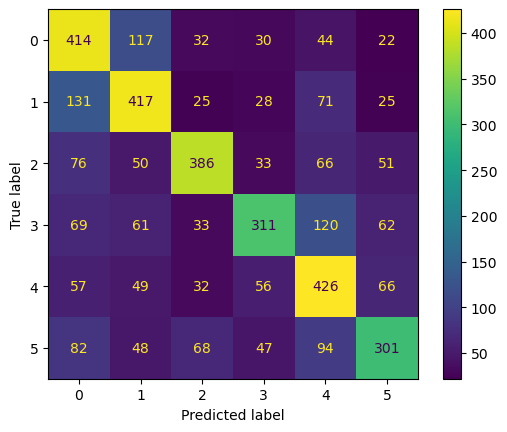

In [15]:
model_utils.plot_and_save_conf_matrix(class_actual=test_dataset['label'],
                                      class_preds=class_preds,
                                      figure_dir_path=".",
                                      figure_filename="test_confmatrix.png")